# Predictive Analysis: ANZ Synthesized 3-month Transactional Dataset

In [495]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Background

Source: https://www.theforage.com/modules/ZLJCsrpkHo9pZBJNY/BiJPfqmGY2QwgN6gA

This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions. The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights gathered from the activities will be genuine.

*NOTE*: Data preprocessing for this dataset was already done in the notebook for Task 1. If reference for data preprocessing is required, please refer to Steps 0 and 1 in the notebook file 'Task 1. Exploratory Data Analysis.ipynb'. The dataset to be loaded here should be the cleaned file named 'DATA/ANZ-synthesized-transactions-cleaned.csv'

## Step 0: Load the dataset and perform EDA

### Overview
The aim of this dataset is to try to understand the features of purchasing behaviour of customers as a predictor metric for modelling expected values for annual pay/ salary

The plan of execution is to configure the best model for predicting customer's annual salary. According to the principle of Occam's Razor, simpler models will be preferred to more complex models, and the generation of models will stop when it can accurately predict new data.

In [511]:
# referencing the cleaned dataset
file = 'DATA/ANZ-synthesized-transactions-cleaned.csv'
# Read file and parse timestamp as the index
df = pd.read_csv(file)

In [512]:
# To display the first 5 rows of the data
df.head()

,timestamp,status,card_present_flag,account,first_name,age,gender,txn_description,balance,amount,...,X,Y,merch_suburb,merch_state,merch_geometry,merch_X,merch_Y,distance,country,card_present_bool
0,2018-08-01 01:01:15+00:00,authorized,1,1598451071,Diana,26,F,POS,35.39,16.25,...,-27.95,153.41,Ashmore,QLD,153.38 -27.99,-27.99,153.38,5.34,Australia,True
1,2018-08-01 01:13:45+00:00,authorized,0,1598451071,Diana,26,F,SALES-POS,21.20,14.19,...,-27.95,153.41,Sydney,NSW,151.21 -33.87,-33.87,151.21,691.63,Australia,False
2,2018-08-01 01:26:15+00:00,authorized,1,1222300524,Michael,38,M,POS,5.71,6.42,...,-33.94,151.23,Sydney,NSW,151.21 -33.87,-33.87,151.21,8.01,Australia,True
3,2018-08-01 01:38:45+00:00,authorized,1,1037050564,Rhonda,40,F,SALES-POS,2117.22,40.90,...,-27.66,153.10,Buderim,QLD,153.05 -26.68,-26.68,153.05,109.20,Australia,True
4,2018-08-01 01:51:15+00:00,authorized,1,1598451071,Diana,26,F,SALES-POS,17.95,3.25,...,-27.95,153.41,Mermaid Beach,QLD,153.44 -28.06,-28.06,153.44,12.60,Australia,True


In [513]:
# check the shape of the DataFrame
df.shape

(12043, 21)

* Rows in dataset: 12043
* Columns in dataset: 21

In [514]:
# display all missing values
df.isna().sum()

timestamp            0
status               0
card_present_flag    0
account              0
first_name           0
age                  0
gender               0
txn_description      0
balance              0
amount               0
geometry             0
X                    0
Y                    0
merch_suburb         0
merch_state          0
merch_geometry       0
merch_X              0
merch_Y              0
distance             0
country              0
card_present_bool    0
dtype: int64

## Step 1: Identify annual salary of each customer

### a) Drop irrelevant features and create dummies

In [515]:
# confirmation of data types prior to conversion
df.dtypes

timestamp             object
status                object
card_present_flag      int64
account                int64
first_name            object
age                    int64
gender                object
txn_description       object
balance              float64
amount               float64
geometry              object
X                    float64
Y                    float64
merch_suburb          object
merch_state           object
merch_geometry        object
merch_X              float64
merch_Y              float64
distance             float64
country               object
card_present_bool       bool
dtype: object

* drop all features that are unrelated to purchasing behaviour, as well as any feature that cannot be converted into a helpful categorical/ numerical dummy vairable:
    - timestamp
    - country
    - card_present_bool
    - merch_suburb (use coords)
    - merch_state (use coords)
    - geometry (use X, Y)
    - merch_geometry
    - merch_X
    - merch_Y
    - distance
* Since we want to group data into an annual salary aggregate table of customer indexes, these dummy variables will need to be merged later on as predictors

In [516]:
df = df.drop(columns=['country', 'timestamp', 'geometry', 'merch_suburb', 'merch_state', 
                       'merch_geometry', 'merch_X', 'merch_Y', 'distance', 'card_present_bool'])

In [517]:
# get dummy variables
df = pd.get_dummies(data=df, columns=['status', 'gender'], prefix=['status', 'gender'], drop_first=True)

In [518]:
df.head()

,card_present_flag,account,first_name,age,txn_description,balance,amount,X,Y,status_posted,gender_M
0,1,1598451071,Diana,26,POS,35.39,16.25,-27.95,153.41,0,0
1,0,1598451071,Diana,26,SALES-POS,21.20,14.19,-27.95,153.41,0,0
2,1,1222300524,Michael,38,POS,5.71,6.42,-33.94,151.23,0,1
3,1,1037050564,Rhonda,40,SALES-POS,2117.22,40.90,-27.66,153.10,0,0
4,1,1598451071,Diana,26,SALES-POS,17.95,3.25,-27.95,153.41,0,0


In [523]:
df.set_index('account', inplace=True)

### b) Subset Pay/Salary transactions and group by account

In [524]:
# display counts of payment types
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [525]:
# Check the distinct values for each column
df.nunique()

card_present_flag        2
first_name              80
age                     33
txn_description          6
balance              12006
amount                4457
X                       85
Y                       87
status_posted            2
gender_M                 2
dtype: int64

- *NOTE*: First name and account column number of unique values do not match up:
     - First name has 80 unique values
     - Account has 100 unique values
- It would be helpful for us to index these by account as it has better unique identification of customers.
- In order to get a good target feature for annual salary, the index should be a sum of all the pay/ salary type descriptions grouped by each account.

In [526]:
#### i) Make Payment transaction Table

In [549]:
df_pay = df[df.txn_description == 'PAY/SALARY']

* Card_present_flag is useless for our prediction model
* Status_posted is not useful in this case because all Pay/ Salary transaction types are functionally dependent on the status of posted. Hence, this column can be dropped
* Basically, all customer unique fields (fully dependent features) have been dropped.
* Only balance is a valid cumulative measure because it is not uniquely identified by the key.

In [550]:
df_pay = df_pay.drop(columns=['card_present_flag', 'age', 'X', 'Y', 'status_posted', 'gender_M'])

In [551]:
df_pay.shape

(883, 4)

* The code shows that there were 883 payment transactions conducted in August, September and October

In [552]:
# Group all payment transactions by accounts and sum
df_pay_sum = df_pay.groupby('account').sum()

In [737]:
# However, payment counts differ for each account
salary_counts = df_pay.index.value_counts()
print(salary_counts)

1598451071    14
2920611728    14
1973887809    14
819621312     14
3326339947    14
              ..
2153562714     3
1217063613     2
3100725361     2
211792489      2
2673069055     2
Name: account, Length: 100, dtype: int64


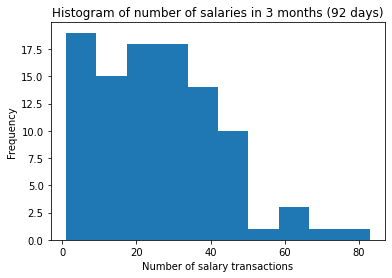

In [738]:
_ = plt.hist(payment_counts)
_ = plt.xlabel('Number of salary transactions')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of salaries in 3 months (92 days)')

* The above payment counts by individual accounts shows that:
    - (35 + 5) = 40 of payment transactions were conducted weekly: 92 / 14 = 6.5714, or 92 / 12 = 7.6 (~7 days)
    - (24 + 27) = 51 of payment transactions were conducted biweekly: 92 / 6 = 15.3333 or 92 / 8 = 11.5 (~14 days)
    - (5 + 2 + 1) = 8 transactions were conducted 92 / 2 = 26, or 92 / 4 = 23, or 92 / 5 = 18.4 (~30 days)
* *NOTE*: The above are just generalizations not exact measures

* Therefore, the payment mean for each account would be a fairly inaccurate scale to be accounting for annual salary.
* Dividing payment sums with the mean of payment counts should give us better scaled features for our data

In [533]:
scaler = payment_counts.mean()

In [534]:
df_pay_standardized = df_pay_sum / scaler

* However, this is not good enough as we want the annual salary
    - Since 365/30 = 12.166667, and 30/8.83 = 3.3975085
    - annual salary = sum_amounts/ 8.83 * 3.3975085 * 12.166667

In [707]:
df_pay_sum['annualized_sal'] = df_pay_sum['amount']/3.3975085 * 12.166667

In [708]:
df_pay_sum.sort_values('annualized_sal', ascending=False)

,balance,amount,annualized_sal
account,,,
1523339231,295834.60,35343.92,126568.544307
1496451953,183287.54,33644.13,120481.501728
3317636250,164255.24,33081.88,118468.053191
2231965366,204657.85,31762.12,113741.919190
240804743,106299.10,30837.10,110429.371095
...,...,...,...
53508546,54704.11,8703.84,31168.935383
2615038700,409793.72,8637.59,30931.690447
2970114956,58334.28,8603.88,30810.973061


In [709]:
df_pay_sum.drop(columns='amount', inplace=True)

In [710]:
# this confirms we have all 100 accounts in new dataset group
df_pay_sum.shape

(100, 2)

In [711]:
df_pay_sum.annualized_sal.describe()

count       100.000000
mean      60039.149965
std       24141.843194
min       25625.890968
25%       41509.206707
50%       53047.914113
75%       76392.923308
max      126568.544307
Name: annualized_sal, dtype: float64

* The max annual salary is **\$126, 568.54** and the min annual salary is **\$25, 625.89**
* This range of salary amounts is not an accurate measure of the entire year, it is a projected annuity based on three months. Therefore, it is useful to keep that in mind when making the predictions.

#### ii) Make other transactiont type tables to add new features to merge

In [562]:
df_sales_pos = df[df.txn_description == 'SALES-POS']

In [563]:
drop_columns = [c for c in df_sales_pos.columns if (c != 'amount' and c != 'account')]
df_sales_pos = df_sales_pos.drop(columns = drop_columns)


In [567]:
df_sales_pos_sum = df_sales_pos.groupby('account').sum()
sales_pos_counts = df_sales_pos.index.value_counts()

In [641]:
df_sales_pos_sum.rename({'amount': 'sales_pos'}, axis=1, inplace=True)

* One customer missing for sales-pos transaction data

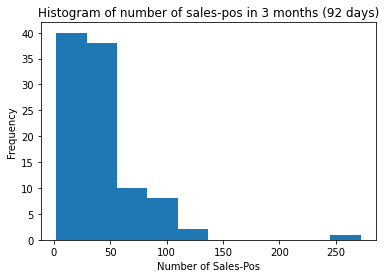

In [569]:
_ = plt.hist(sales_pos_counts)
_ = plt.xlabel('Number of Sales-Pos')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of sales-pos in 3 months (92 days)')

In [570]:
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [577]:
df_pos = df[df.txn_description == 'POS']

In [578]:
drop_columns = [c for c in df_pos.columns if (c != 'amount' and c != 'account')]
df_pos = df_pos.drop(columns = drop_columns)

In [579]:
df_pos_sum = df_pos.groupby('account').sum()
pos_counts = df_pos.index.value_counts()

In [642]:
df_pos_sum.rename({'amount': 'pos'}, axis=1, inplace=True)

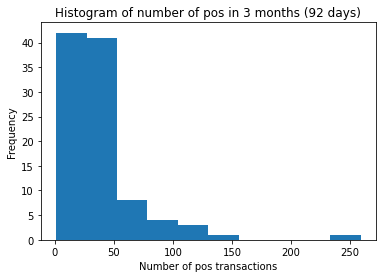

In [589]:
_ = plt.hist(pos_counts)
_ = plt.xlabel('Number of pos transactions')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of pos in 3 months (92 days)')

In [739]:
df_payment = df[df.txn_description == 'PAYMENT']

In [740]:
drop_columns = [c for c in df_payment.columns if (c != 'amount' and c != 'account')]
df_payment = df_payment.drop(columns = drop_columns)

In [741]:
df_payment_sum = df_payment.groupby('account').sum()
payment_counts = df_payment.index.value_counts()

In [742]:
df_payment_sum.rename({'amount': 'payment'}, axis=1, inplace=True)

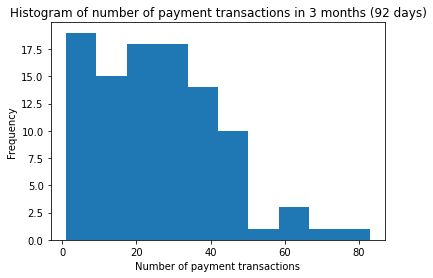

In [743]:
_ = plt.hist(payment_counts)
_ = plt.xlabel('Number of payment transactions')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of payment transactions in 3 months (92 days)')

In [593]:
df_interbank = df[df.txn_description == 'INTER BANK']

In [594]:
drop_columns = [c for c in df_interbank.columns if (c != 'amount' and c != 'account')]
df_interbank = df_interbank.drop(columns = drop_columns)

In [595]:
df_interbank_sum = df_interbank.groupby('account').sum()
interbank_counts = df_interbank.index.value_counts()

In [727]:
df_interbank_sum.rename({'amount': 'inter_bank'}, axis=1, inplace=True)

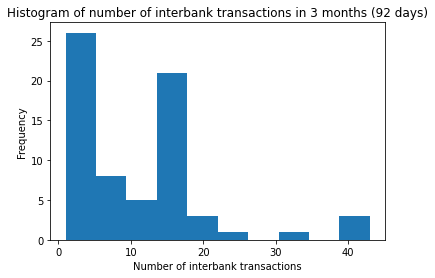

In [596]:
_ = plt.hist(interbank_counts)
_ = plt.xlabel('Number of interbank transactions')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of interbank transactions in 3 months (92 days)')

In [599]:
df_phonebank = df[df.txn_description == 'PHONE BANK']

In [600]:
drop_columns = [c for c in df_phonebank.columns if (c != 'amount' and c != 'account')]
df_phonebank = df_phonebank.drop(columns = drop_columns)

In [601]:
df_phonebank_sum = df_phonebank.groupby('account').sum()
phonebank_counts = df_phonebank.index.value_counts()

In [728]:
df_phonebank_sum.rename({'amount': 'phone_bank'}, axis=1, inplace=True)

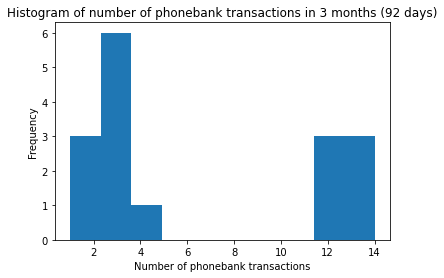

In [647]:
_ = plt.hist(phonebank_counts)
_ = plt.xlabel('Number of phonebank transactions')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram of number of phonebank transactions in 3 months (92 days)')

In [745]:
dfs = [df_pay_sum, df_sales_pos_sum, df_pos_sum, df_payment_sum, df_interbank_sum, df_phonebank_sum] # list of dataframes

dfm = dfs[0].merge(dfs[1], how='inner', on='account') \
            .merge(dfs[2], how='inner', on='account') \
            .merge(dfs[3], how='inner', on='account') \
#             .merge(dfs[4], how='inner', on='account') \
#             .merge(dfs[5], how='inner', on='account') 


In [746]:
dfm

,balance,annualized_sal,sales_pos,pos,payment
account,,,,,
37709441,98107.03,103584.219036,399.84,663.05,2088.0
38923874,506145.72,87565.226052,734.41,1716.74,4671.0
53508546,54704.11,31168.935383,1204.22,350.31,1180.0
80388494,35050.32,41178.773749,3033.07,1356.47,852.0
90814749,65301.33,49604.854445,1472.62,1845.16,831.0
...,...,...,...,...,...
4065652575,83700.42,89707.413540,3369.45,606.37,3957.0
4163822186,94134.87,39565.364938,104.55,19.76,2442.0
4258502723,51624.95,49339.498221,2662.22,3667.82,1984.0


In [715]:
dfm.shape

(99, 5)

### c) Merge a customer table with pay/salary table

* Here, a customer table is extracted from the original data, dropping everything that is not fully dependent on the primary key, satisfying 3NF.
* The reason why the cleaning is done for 3NF here is because most of the cleaning has already met 1NF and 2NF rules, even though we are not making relational tables.

In [747]:
df.head()

,card_present_flag,first_name,age,txn_description,balance,amount,X,Y,status_posted,gender_M
account,,,,,,,,,,
1598451071,1,Diana,26,POS,35.39,16.25,-27.95,153.41,0,0
1598451071,0,Diana,26,SALES-POS,21.20,14.19,-27.95,153.41,0,0
1222300524,1,Michael,38,POS,5.71,6.42,-33.94,151.23,0,1
1037050564,1,Rhonda,40,SALES-POS,2117.22,40.90,-27.66,153.10,0,0
1598451071,1,Diana,26,SALES-POS,17.95,3.25,-27.95,153.41,0,0


* To avoid the inclusion of duplicate values, customer table should be in 3NF

In [748]:
df_cust = df[['age', 'X', 'Y']]

*NOTE*: The reason why X and Y is considered to be fully dependent on the customer account number is because they represent the location of the customer

In [749]:
df_cust = df_cust.drop_duplicates()

In [750]:
df_cust.sort_index().head()

,age,X,Y
account,,,
37709441,18,-28.01,153.41
38923874,38,-33.90,151.27
53508546,35,-33.76,150.62
80388494,28,-37.42,144.97
90814749,35,-32.98,151.68


In [751]:
dfm.sort_index().head()

,balance,annualized_sal,sales_pos,pos,payment
account,,,,,
37709441,98107.03,103584.219036,399.84,663.05,2088.0
38923874,506145.72,87565.226052,734.41,1716.74,4671.0
53508546,54704.11,31168.935383,1204.22,350.31,1180.0
80388494,35050.32,41178.773749,3033.07,1356.47,852.0
90814749,65301.33,49604.854445,1472.62,1845.16,831.0


In [752]:
df_merged = df_cust.merge(dfm, how='inner', on='account').sort_index()

In [753]:
df_merged.shape

(99, 8)

In [754]:
df_merged.head()

,age,X,Y,balance,annualized_sal,sales_pos,pos,payment
account,,,,,,,,
37709441,18,-28.01,153.41,98107.03,103584.219036,399.84,663.05,2088.0
38923874,38,-33.90,151.27,506145.72,87565.226052,734.41,1716.74,4671.0
53508546,35,-33.76,150.62,54704.11,31168.935383,1204.22,350.31,1180.0
80388494,28,-37.42,144.97,35050.32,41178.773749,3033.07,1356.47,852.0
90814749,35,-32.98,151.68,65301.33,49604.854445,1472.62,1845.16,831.0


## Step 2: Explore correlations between annual salary and various customer attributes

In [755]:
df_merged.corr()['annualized_sal']

age               0.009027
X                -0.086803
Y                -0.033711
balance           0.249791
annualized_sal    1.000000
sales_pos         0.112323
pos              -0.082584
payment           0.626551
Name: annualized_sal, dtype: float64

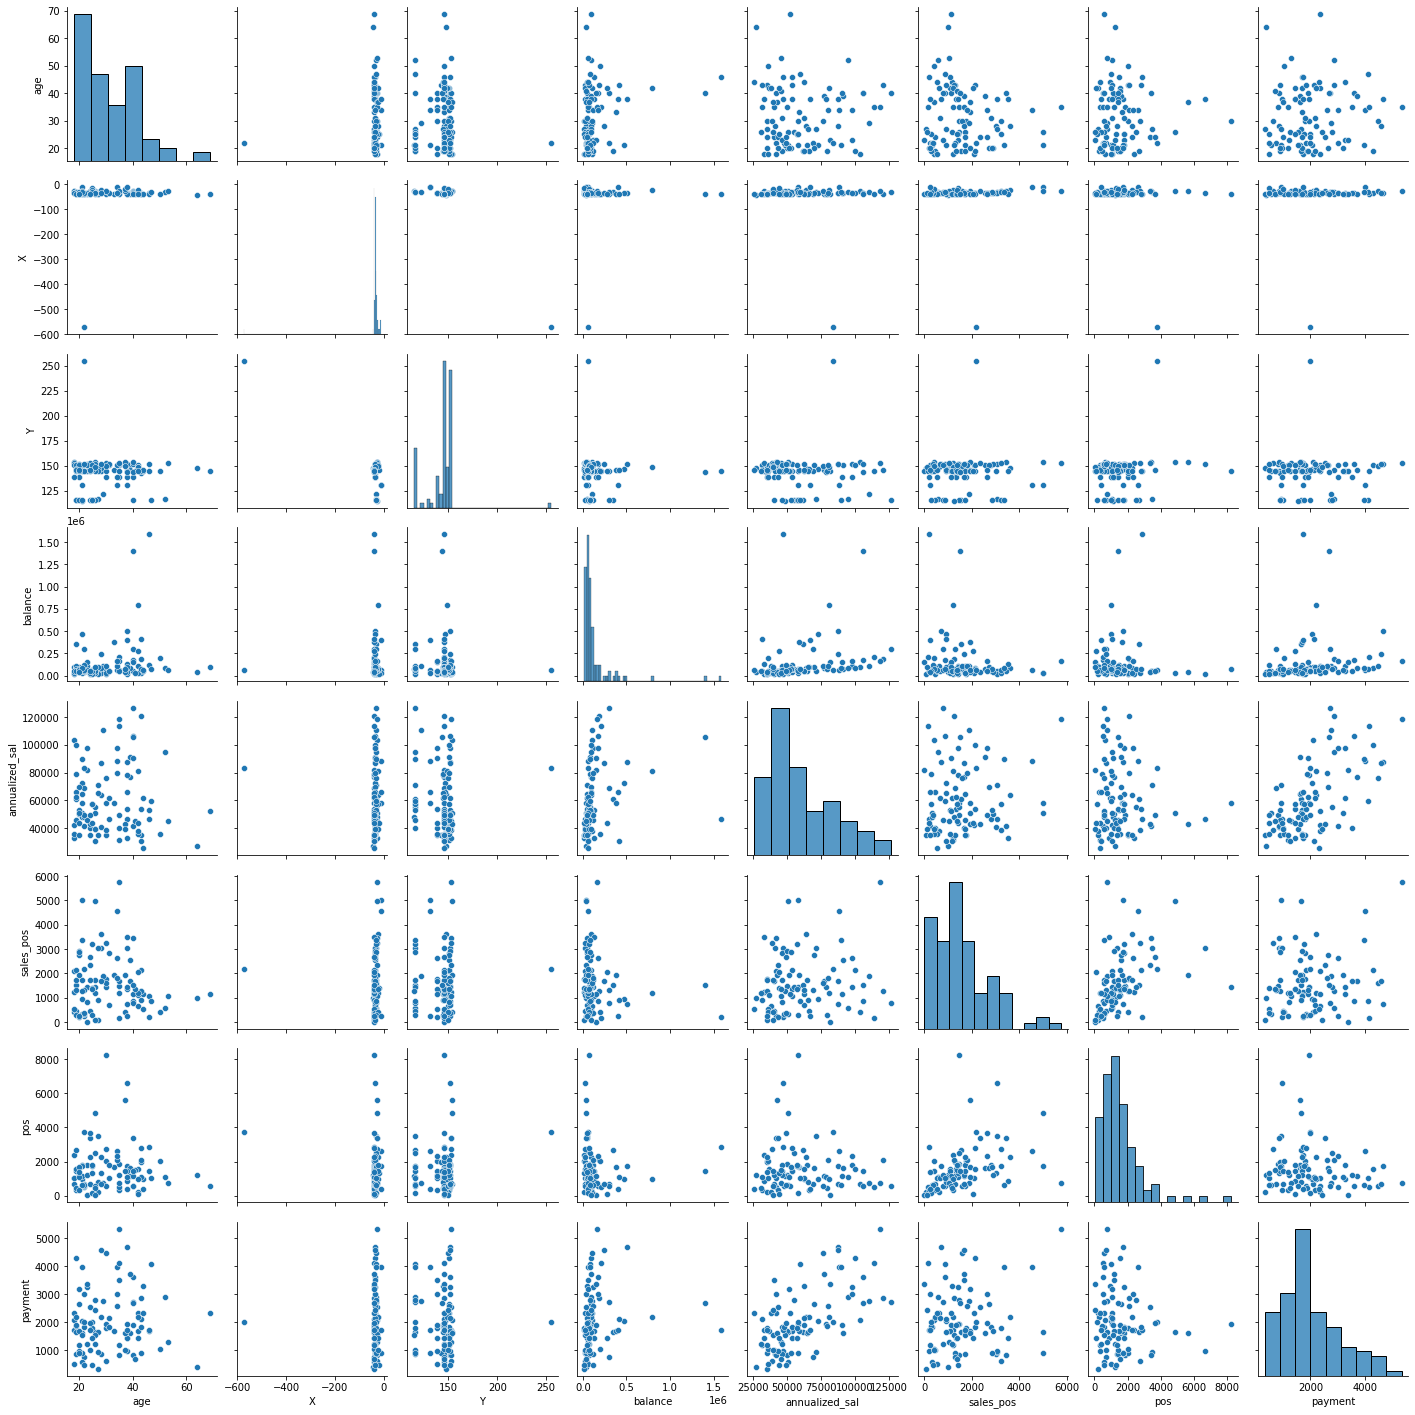

In [756]:
sns.pairplot(df_merged)

* Drop features that don't have a strong correlation with annualized amount

## Step 3: Build linear regression model to predict annual salary

### a) Feature selection

In [758]:
features = list(set(df_merged.columns) - set(df_merged[['annualized_sal']]))

In [760]:
X = df_merged[features]
y = df_merged['annualized_sal']
X.head()

,sales_pos,payment,balance,X,pos,age,Y
account,,,,,,,
37709441,399.84,2088.0,98107.03,-28.01,663.05,18,153.41
38923874,734.41,4671.0,506145.72,-33.90,1716.74,38,151.27
53508546,1204.22,1180.0,54704.11,-33.76,350.31,35,150.62
80388494,3033.07,852.0,35050.32,-37.42,1356.47,28,144.97
90814749,1472.62,831.0,65301.33,-32.98,1845.16,35,151.68


In [761]:
# Normalize X using a StandardScalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [762]:
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,sales_pos,payment,balance,X,pos,age,Y
0,-1.022947,0.054719,-0.175010,0.196154,-0.667597,-1.260038,0.608855
1,-0.734391,2.445365,1.604700,0.087629,0.131509,0.634325,0.476704
2,-0.329195,-0.785664,-0.364317,0.090208,-0.904775,0.350170,0.436565
3,1.248128,-1.089238,-0.450039,0.022771,-0.141715,-0.312857,0.087664
4,-0.097709,-1.108674,-0.318096,0.104580,0.228901,0.350170,0.502023
...,...,...,...,...,...,...,...
94,1.538244,1.784536,-0.237846,0.125954,-0.710582,-0.975884,-1.713039
95,-1.277624,0.382357,-0.192335,0.067913,-1.155460,-0.502293,0.338379
96,0.928282,-0.041537,-0.377747,0.016875,1.611185,-0.691730,0.117305
97,-1.166737,-0.782887,-0.419726,0.014664,-0.131833,-1.070602,0.103719


In [763]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [764]:
## Flag intermediate output

show_steps = True   # for testing/debugging
# show_steps = False  # without showing steps

In [765]:
## Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression() # create a model for Linear Regression
# get the number of cases in the test data
n = X_test.shape[0]
if show_steps:
        print('n is:', n)  

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train) # fit a model; consider which predictors should be included
        # calculate the score (R^2 for Regression)
        if show_steps:
            print('Model fitted:', fit)
        r2 = fit.score(X_train[included + [new_column]], y_train) # calculate the score
        if show_steps:
            print('Score of model:', r2)
        # number of predictors in this model
        k = len(included) + 1
        if show_steps:
            print('Number of predictors:', k)
        # calculate the adjusted R^2
        adjusted_r2 = 1 - (1-r2)*(n-1)/(n-k-1) # calculate the Adjusted R^2
        if show_steps:
            print('Adjusted R^2:', adjusted_r2)
        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            if show_steps:
                print('Found a better model than previous regressor...')
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        break

print('')
print('Resulting features:')
print(', '.join(included))

n is: 20

(Step) Excluded = X, payment, sales_pos, pos, age, balance, Y
(Step) Trying X...
(Step) - Features = X
Model fitted: LinearRegression()
Score of model: 0.012764681137065748
Number of predictors: 1
Adjusted R^2: -0.04208172546643052
(Step) - Adjusted R^2: This = -0.042; Best = 0.000
(Step) Trying payment...
(Step) - Features = payment
Model fitted: LinearRegression()
Score of model: 0.3030924365578993
Number of predictors: 1
Adjusted R^2: 0.26437534970000476
(Step) - Adjusted R^2: This = 0.264; Best = 0.000
Found a better model than previous regressor...
(Step) - New Best!   : Feature = payment; R^2 = 0.303; Adjusted R^2 = 0.264
(Step) Trying sales_pos...
(Step) - Features = sales_pos
Model fitted: LinearRegression()
Score of model: 0.0005323544447012329
Number of predictors: 1
Adjusted R^2: -0.05499362586392653
(Step) - Adjusted R^2: This = -0.055; Best = 0.264
(Step) Trying pos...
(Step) - Features = pos
Model fitted: LinearRegression()
Score of model: 6.593692845757726e-05
